# Cosmoformer model training and evaluating

## Step 0: Environment dependencies setup

Update PIP package manager

In [ ]:
%pip install --upgrade pip

Run the cell below to intall PyThorch library with dependecies based on your hardware.  
Select PyTorch installation type:
1. CPU
2. Nvidia GPU
3. AMD GPU
4. Apple Silicon

In [ ]:
# If you see any error, please, check the Python version.
# Last tested Python version is 3.12.

choice = input("Select PyTorch installation type:\n"
               "1. CPU\n"
               "2. Nvidia GPU\n"
               "3. AMD GPU\n"
               "4. Apple Silicon\n"
               "Enter the number corresponding to your choice: ")

if choice == "1":
    print("Installing PyTorch for CPU...")
    !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    
elif choice == "2":
    print("Installing PyTorch for Nvidia GPU...")
    !pip3 install torch torchvision torchaudio
elif choice == "3":
    print("Installing PyTorch for AMD GPU...")
    !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/rocm6.2
elif choice == "4":
    print("Installing PyTorch for Apple Silicon...")
    !pip3 install torch torchvision torchaudio
else:
    print("Invalid choice. Please run the cell again and select a valid option.")


Installind external libraries

In [ ]:
!pip3 install matplotlib
!pip3 install scikit-learn
!pip3 install pandas
!pip3 install pyarrow
!pip3 install tqdm              # Progress meter
!pip3 install vit-pytorch       # Crossformer model

Add Git LFS support (optional)

In [ ]:
# !git lfs install
# !git lfs track "*.pth"
# !git add .gitattributes

## Step 1: Import dependencies

In [ ]:
import os
import math
import datetime
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from tqdm.auto import tqdm
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from vit_pytorch.crossformer import CrossFormer
from torch.amp import autocast, GradScaler
from torchvision.transforms.v2.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
num_workers = max((os.cpu_count() or 1) - 1, 0)
device, num_workers

## Step 2: Define dataset

In [ ]:
class ParquetImageDataset(Dataset):
    """
    A PyTorch Dataset that reads a Parquet file containing:
      - img_path: path to image on disk
      - label (str): label of the image (e.g., 'spiral', 'smooth', etc.)
    """
    def __init__(self, parquet_file, transform=None, label_encoder=None):
        super().__init__()
        self.data = pd.read_parquet(parquet_file)
        self.transform = transform
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = "cosmoformer-dataset/"+row['img_path']
        label_str = row['label']

        image = Image.open(img_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        if self.label_encoder is not None:
            label = self.label_encoder.transform([label_str])[0]
            label = torch.tensor(label, dtype=torch.long)
        else:
            label = label_str

        return image, label


In [ ]:
TRAIN_DATASET_PATH = "cosmoformer-dataset/train.parquet"
VALIDATION_DATASET_PATH = "cosmoformer-dataset/validation.parquet"
TEST_DATASET_PATH = "cosmoformer-dataset/test.parquet"

In [ ]:
train_df = pd.read_parquet(TRAIN_DATASET_PATH)
val_df   = pd.read_parquet(VALIDATION_DATASET_PATH)
test_df  = pd.read_parquet(TEST_DATASET_PATH)

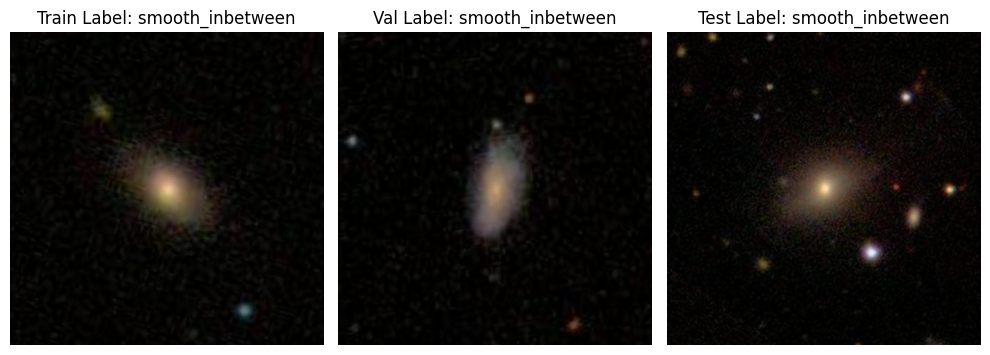

In [18]:
train_image, train_label = train_df['img_path'][0], train_df['label'][0]
val_image, val_label = val_df['img_path'][0], val_df['label'][0]
test_image, test_label = test_df['img_path'][0], test_df['label'][0]

train_image = Image.open("cosmoformer-dataset/" + train_image)
val_image = Image.open("cosmoformer-dataset/" + val_image)
test_image = Image.open("cosmoformer-dataset/" + test_image)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(train_image)
axes[0].set_title(f"Train Label: {train_label}")
axes[0].axis('off')

axes[1].imshow(val_image)
axes[1].set_title(f"Val Label: {val_label}")
axes[1].axis('off')

axes[2].imshow(test_image)
axes[2].set_title(f"Test Label: {test_label}")
axes[2].axis('off')


plt.tight_layout()
plt.show()


In [19]:
all_labels = pd.concat([train_df['label'], val_df['label'], test_df['label']])
le = LabelEncoder()
le.fit(all_labels)

print("Classes found:", le.classes_, len(le.classes_))

Classes found: ['barred_spiral' 'edge_on_disk' 'featured_without_bar_or_spiral'
 'irregular' 'smooth_cigar' 'smooth_inbetween' 'smooth_round'
 'unbarred_spiral'] 8


## Step 3: Define On-the-Fly Augmentation

In [ ]:
train_transform = v2.Compose([
    v2.RandomResizedCrop(
        size=(224, 224),
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1),
        interpolation=InterpolationMode.BILINEAR
    ),
    v2.RandomRotation(
        degrees=(-180, 180),
        interpolation=InterpolationMode.BILINEAR
    ),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,
        hue=0.0
    ),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])  # v2.ToTensor()
])

val_test_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])  # v2.ToTensor()
])

## Step 4: Load Datasets

In [ ]:
train_dataset = ParquetImageDataset(
    parquet_file=TRAIN_DATASET_PATH,
    transform=train_transform,
    label_encoder=le
)

validation_dataset = ParquetImageDataset(
    parquet_file=VALIDATION_DATASET_PATH,
    transform=val_test_transform,
    label_encoder=le
)

test_dataset = ParquetImageDataset(
    parquet_file=TEST_DATASET_PATH,
    transform=val_test_transform,
    label_encoder=le
)

print("Train train set size:", len(train_dataset))
print("Validation set size:", len(validation_dataset))
print("Test set size:", len(test_dataset))

## 3. Class Weights + Sampler

In [ ]:
class_counts = train_df['label'].value_counts()
class_counts

In [ ]:
num_classes = len(le.classes_)
weight_array = np.zeros(num_classes, dtype=np.float32)

# Loop through each class label (as a string) in le.classes_, find how many samples it has, and compute 1 / frequency
for class_str in le.classes_:
    class_idx = le.transform([class_str])[0]
    count = class_counts[class_str]
    weight_array[class_idx] = 1.0 / count

class_weights_tensor = torch.tensor(weight_array, dtype=torch.float32).to(device)
class_weights_tensor

In [ ]:
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

train_loader, val_loader, test_loader

## Step 5: Initialize CrossFormer Model

In [ ]:
model = CrossFormer(
    num_classes=len(le.classes_),
    dim=(32, 64, 128, 256),
    depth=(2, 2, 4, 2),
    global_window_size=(8, 4, 2, 1),
    local_window_size=7,
    attn_dropout=0.1,
    ff_dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

## Step 7: Training Loop

In [ ]:
os.makedirs("checkpoints", exist_ok=True) # directory for checkpoints store

try:
    best_val_acc = checkpoint['val_acc'] 
except:
    best_val_acc = 0.0

num_epochs = 20
warmup_epochs = round(num_epochs * 0.1)
base_lr = 2e-6
weight_decay = 1e-4

def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return float(epoch + 1) / warmup_epochs
    else:
        progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        return 0.5 * (1.0 + math.cos(math.pi * progress))

scaler = GradScaler("cuda")
optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

print(f"Total number of epochs: {num_epochs}")
print(f"The number of warm up epochs: {warmup_epochs}")

In [ ]:
for epoch in range(num_epochs):
    print(f"\nCurrent LR: {scheduler.get_last_lr()[0]:.2e}")
    
    ################################
    #          Training            #
    ################################
    model.train()
    running_train_loss = 0.0
    
    train_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", smoothing=0.9)
    
    for images, labels in train_tqdm:
        images, labels = images.to(device), labels.to(device)

        # Zero out the gradients
        optimizer.zero_grad()
        
        # 2) Mixed precision forward pass
        with autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # 3) Backprop with scaled loss
        scaler.scale(loss).backward()
        
        # 4) Gradient clipping AFTER unscaling
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # 5) Step the optimizer with scaled gradients
        scaler.step(optimizer)
        scaler.update()
        
        running_train_loss += loss.item()
        train_tqdm.set_postfix(loss=loss.item())
        
    train_loss = running_train_loss / len(train_loader)

    ################################
    #         Validation           #
    ################################
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0

    val_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", smoothing=0.9)
    with torch.no_grad():
        for images, labels in val_tqdm:
            images, labels = images.to(device), labels.to(device)
            
            # Mixed precision inference also possible (faster on GPUs)
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)

            val_tqdm.set_postfix(loss=loss.item())

    val_loss = running_val_loss / len(val_loader)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] Summary: "
          f"Train Loss={train_loss:.4f}  |  Val Loss={val_loss:.4f}  |  Val Acc={val_acc:.4f}")
    
    # Checkpoint saving logic
    if ((epoch/num_epochs) <= 0.50 and (val_acc - best_val_acc) > 0.01) \
       or ((epoch/num_epochs) < 0.75 and (val_acc - best_val_acc) > 0.005) \
       or ((epoch/num_epochs) >= 0.75 and val_acc > best_val_acc):
        best_val_acc = val_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc
        }
        checkpoint_filename = f"checkpoints/{val_acc:.4f}_epoch_{epoch+1}_{datetime.datetime.today().strftime('%Y%m%d')}.pth"
        torch.save(checkpoint, checkpoint_filename)
        print(f"New best model saved: {checkpoint_filename}")
    
    scheduler.step()


## Step 8: Test Set Evaluation

In [20]:
### Load model from previous training:

checkpoint_path = "checkpoints/0.7548_epoch_50_20250305.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [21]:
model.eval()

test_loss = 0.0
correct = 0
total = 0

test_tqdm = tqdm(test_loader, desc="Testing", smoothing=0.9)

with torch.no_grad():
    for images, labels in test_tqdm:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        test_tqdm.set_postfix(loss=loss.item())

test_loss /= len(test_loader)
test_acc = correct / total

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Testing:   0%|          | 0/655 [00:00<?, ?it/s]

/home/artursultanov/uni/cosmoformer-model/venv/lib64/python3.12/site-packages/torch/functional.py:402: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return _VF.einsum(equation, operands)  # type: ignore[attr-defined]


Test Loss: 0.8010 | Test Acc: 0.7599


## Step 9: Single Prediction

In [22]:
# Example label mapping
label_mapping = {
    0: 'barred_spiral',
    1: 'edge_on_disk',
    2: 'featured_without_bar_or_spiral',
    3: 'irregular',
    4: 'smooth_cigar',
    5: 'smooth_inbetween',
    6: 'smooth_round',
    7: 'unbarred_spiral'
}

idx = random.randint(0, len(train_dataset) - 1)

example_image_tensor, example_label_int = train_dataset[idx]

example_image_tensor = example_image_tensor.unsqueeze(0).to(device)

# Run inference
model.eval()
with torch.no_grad():
    output = model(example_image_tensor)        # shape [1, num_classes]
    _, pred_idx = torch.max(output, dim=1)      # Get predicted class index
    pred_idx = pred_idx.item()                  # convert to int

real_truth_class_name = label_mapping[example_label_int.item()]
predicted_class_name = label_mapping[pred_idx]

print("Random sample index:", idx)
print("Predicted class index:", pred_idx)
print("Predicted class:", predicted_class_name)
print("Real truth class index:", example_label_int.item())
print("Real truth class:", real_truth_class_name)

Random sample index: 108976
Predicted class index: 5
Predicted class: smooth_inbetween
Real truth class index: 5
Real truth class: smooth_inbetween
